In [41]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
from simplejson import JSONDecodeError
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import random
import time 

In [42]:
def parse_json(filepath):
    """
    function used to parse json of each commit json file

    Args:
        filepath_list - list of filepaths

    Returns:
        files_json - list object contains parsed information

    """

    files_json = []

    # each commits
    files = os.listdir(filepath)
    for path in files:
        if os.stat(filepath + path).st_size != 0 and path != 'desktop.ini':
            with open(filepath + path, encoding="utf8") as f:
                data = json.load(f)
                files_list = []
                # each file in commits
                for file in data['files']:
                    # parse only cluster file
                    for key in file.keys():
                        if re.match('^.*_cluster$', key):
                            actions_list = []
                            actions = file[key]['actions']
                            # each action in file
                            for action in actions:
                                actions_list.append(action['root'])
                            files_list.append(actions_list)
            if len(files_list) != 0:
                files_json.append(files_list)
    # return
    return files_json


folder_path = 'C:\\Users\\ichel\\Desktop\\shared_ReFiles\\AllFiles_Research\\'
all_files = parse_json(folder_path)

In [43]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0].strip()
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()] + [
                        temp.split('INS ')[1].rsplit('to ')[-1].strip()
                    ]
                    for items in words:
                        items = items.split(':')[0].strip()
                        tempq.append(items)
                    if tempq[1] == 'TextElement' and tempq[-1] not in ['TagElement', 'TextElement']:
                        tempq[-1] = ''
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split('from ')[1].strip()
                    tempq.append('MOVE')
                    tempq.append(temp2.split(':')[0].strip())
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(':')[0].strip())
                    temp = '_'.join(tempq)
                temp = temp.replace(' ', '_')
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i
        i += 1
    return dic, files_data, counting

In [44]:
_, datas, _ = preprocess_roots(all_files)

<sample training data>:  ['INS_MethodDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration UPDATE INS_TagElement_TagElement INS_TextElement_TagElement INS_FieldAccess_ArrayAccess DEL_SimpleName', 'INS_TypeDeclaration_TypeDeclaration INS_FieldDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration MOVE_TypeDeclaration INS_Javadoc_MethodDeclaration MOVE_Block INS_Javadoc_MethodDeclaration INS_SimpleType_MethodDeclaration UPDATE MOVE_MethodDeclaration INS_Modifier_FieldDeclaration INS_Modifier_FieldDeclaration INS_ExpressionStatement_Block UPDATE INS_QualifiedName_ReturnStatement INS_FieldAccess_Assignment INS_ClassInstanceCreation_Assignment INS_QualifiedName_MethodInvocation INS_QualifiedName_Assignment INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation DEL_Modifier DEL_SimpleName DEL_MethodInvocation DEL_

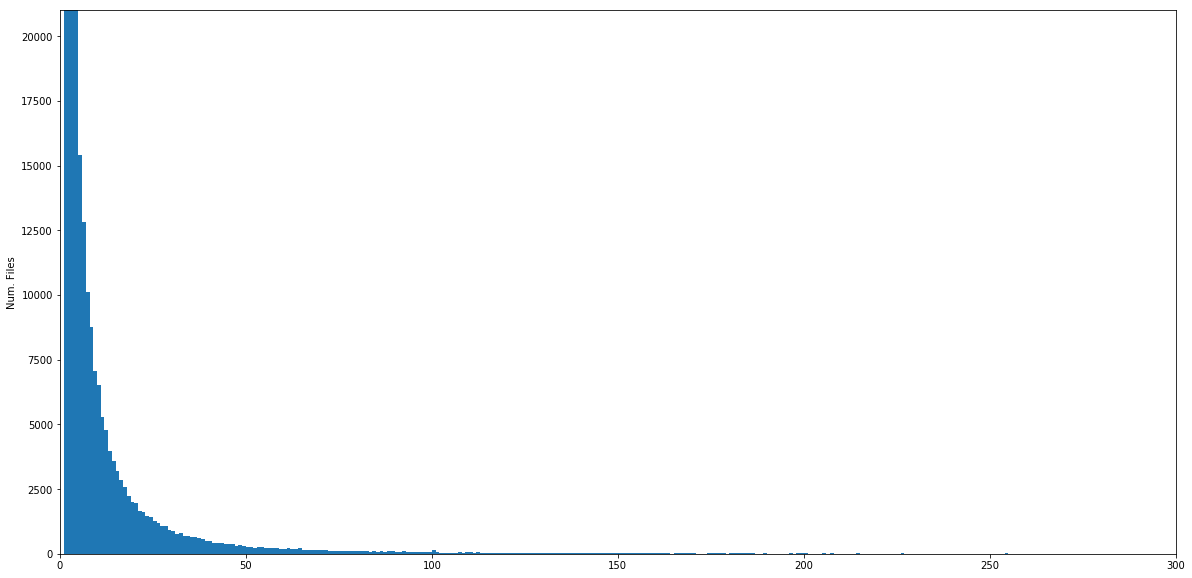

In [45]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for items in training_data:
        for item in items:
            seqlength_list.append(len(item.split(" ")))
            if len(item.split(" ")) >  max_root_len: 
                max_root_len = len(item.split(" "))
    return max_root_len, seqlength_list

def plot_hist(seqlength_list):
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)
    plt.ylabel("Num. Files")
    plt.xlim((0, 300))
    plt.ylim((0, 21000))

max_seqlength, sequence_list = get_seqlength(training_data)
print("<sample training data>: ", training_data[0])
plot_hist(sequence_list)

## Concatenate Data 

In [46]:
def concat_files_to_sentence(expanded_train_list): 
    concat_data = ""
    tmp_list = []
    for items in expanded_train_list:
        concat_data = " ".join(items)
        tmp_list.append(concat_data)
    return tmp_list

concat_data = concat_files_to_sentence(training_data)
print(concat_data[0])

INS_MethodDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration UPDATE INS_TagElement_TagElement INS_TextElement_TagElement INS_FieldAccess_ArrayAccess DEL_SimpleName INS_TypeDeclaration_TypeDeclaration INS_FieldDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration MOVE_TypeDeclaration INS_Javadoc_MethodDeclaration MOVE_Block INS_Javadoc_MethodDeclaration INS_SimpleType_MethodDeclaration UPDATE MOVE_MethodDeclaration INS_Modifier_FieldDeclaration INS_Modifier_FieldDeclaration INS_ExpressionStatement_Block UPDATE INS_QualifiedName_ReturnStatement INS_FieldAccess_Assignment INS_ClassInstanceCreation_Assignment INS_QualifiedName_MethodInvocation INS_QualifiedName_Assignment INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation INS_QualifiedName_MethodInvocation DEL_Modifier DEL_SimpleName DEL_MethodInvocation DEL_SimpleName DEL_SimpleName DEL_

## Tokenize Training Data 

In [47]:
from keras.preprocessing.text import Tokenizer 
tokenized_sentence = Tokenizer(filters = '', lower=False)
tokenized_sentence.fit_on_texts(concat_data)

sequence = tokenized_sentence.texts_to_sequences(concat_data)
print(sequence[0])

vocabulary = tokenized_sentence.word_index 
vocabulary_inv = dict ((v, k) for k, v in vocabulary.items())
print("Reserve dictionary size: ", len(vocabulary_inv))

[5, 5, 1, 45, 9, 458, 7, 70, 13, 5, 5, 50, 46, 6, 46, 61, 1, 10, 56, 56, 8, 1, 226, 145, 181, 55, 200, 55, 55, 55, 55, 55, 35, 7, 14, 7, 7, 7, 84, 7, 7, 7, 7, 145, 114, 31, 31]
Reserve dictionary size:  831


## Embed Data 

In [48]:
from __future__ import print_function
from gensim.models import word2vec
from os.path import join, exists, split
import os
import numpy as np


def train_word2vec(sentence_matrix, vocabulary_inv,
                   num_features=64, min_word_count=1, context=10):
    """
    Trains, saves, loads Word2Vec model
    Returns initial weights for embedding layer.
   
    inputs:
    sentence_matrix # int matrix: num_sentences x max_sentence_len
    vocabulary_inv  # dict {int: str}
    num_features    # Word vector dimensionality                      
    min_word_count  # Minimum word count                        
    context         # Context window size 
    """
    model_dir = 'models'
    model_name = "{:d}features_{:d}minwords_{:d}context".format(num_features, min_word_count, context)
    model_name = join(model_dir, model_name)
    if exists(model_name):
        embedding_model = word2vec.Word2Vec.load(model_name)
        print('Load existing Word2Vec model \'%s\'' % split(model_name)[-1])
    else:
        # Set values for various parameters
        num_workers = 4  # Number of threads to run in parallel
        downsampling = 1e-3  # Downsample setting for frequent words

        # Initialize and train the model
        print('Training Word2Vec model...')
        sentences = [[vocabulary_inv[w] for w in s] for s in sentence_matrix]
        embedding_model = word2vec.Word2Vec(sentences, workers=num_workers,
                                            size=num_features, min_count=min_word_count,
                                            window=context, sample=downsampling)

        # If we don't plan to train the model any further, calling 
        # init_sims will make the model much more memory-efficient.
        embedding_model.init_sims(replace=True)

        # Saving the model for later use. You can load it later using Word2Vec.load()
        if not exists(model_dir):
            os.mkdir(model_dir)
        print('Saving Word2Vec model \'%s\'' % split(model_name)[-1])
        embedding_model.save(model_name)

    # add unknown words
    embedding_weights_inv = {key: embedding_model[word] if word in embedding_model else
                              np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                         for key, word in vocabulary_inv.items()}
    embedding_weights = {word: embedding_model[word] if word in embedding_model else
                              np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                         for key, word in vocabulary_inv.items()}
    return embedding_weights_inv, embedding_weights, num_features 

In [49]:
_, embed_dic, embedding_dim = train_word2vec(sequence, vocabulary_inv)

Load existing Word2Vec model '64features_1minwords_10context'


c:\users\ichel\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
c:\users\ichel\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:52: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
c:\users\ichel\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
c:\users\ichel\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [50]:
embedding_filename = "embedding_genism_" + str(embedding_dim) + "_dic.txt"
pad_token = "<PAD/>"
if os.path.exists(embedding_filename): 
    os.remove(embedding_filename)
else:
    with open(embedding_filename, "w") as f:
        pad_embed = np.zeros(embedding_dim)
        for key, val in embed_dic.items():
            f.write("%s %s\n"%(key, " ".join(map(str, val))))
        f.write("%s %s\n"%(pad_token, " ".join(map(str, pad_embed))))